# Income Level Prediction (Annual Income >= 50K?)

## Task Description
* This dataset was extracted by by Barry Becker from the 1994 Census database. A set of reasonably clean records was extracted using the specific conditions.

* Prediction task is to determine whether a person makes over 50K a year given the census information. 

* There are 14 attributes, including continuous, categorical and integer types. Some attributes may have missing values, recorded as question marks.

## Relevant Paper 
Ron Kohavi, "Scaling Up the Accuracy of Naive-Bayes Classifiers: a Decision-Tree Hybrid", Proceedings of the Second International Conference on Knowledge Discovery and Data Mining, 1996. (PDF)

## Evaluation
* The evaluation is based on Area Under ROC (AUC) curve, which is a value between 0 and 1. The higher AUC, the better the predictive performance. Note that AUC is the most commonly used measure in ML practice. It considers the cases of all possible thresholds that are used for (binary) classification, and calculates the area of the (TPR, FPR) curve of using these thresholds (TPR and FPR stands for True Positive Rate and False Positive Rate, respectively) as an overall measure of the model performance. Therefore, AUC is not restricted to the accuracy of any single threshold (e.g., 0.5 or 0). It is a comprehensive evaluation. A detailed introduction of AUC is given here - https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5


* The file should contain a header and have the following format:

ID,Prediction

3,0.3

8,-0.2

10,0.55

...

## Dataset - Attributes
* age: continuous
* workclass: {Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked}
* fnlwgt: continuous
* education: {Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool}
* education-num: continuous.
* marital-status: {Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse}
* occupation: {Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces}
* relationship: {Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried}
* race: {White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black}
* sex: {Female, Male}
* capital-gain: continuous.
* capital-loss: continuous.
* hours-per-week: continuous.
* native-country: {United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands}

## Dataset - Target
income > 50K: binary

## Import Libraries and Training Data

In [26]:
# Import Libraries

import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt 
import plotly.graph_objects as go
import matplotlib




import matplotlib.mlab as mlab
import seaborn as sb

%matplotlib inline

In [27]:
# Input data files (code for kaggle only)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [28]:
# Read training data and display

train_data = pd.read_csv("train_final.csv")
#train_data = pd.read_csv("../input/Income prediction/train_final/train_final.csv")
train_data.head(5)

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income>50K
0,53,Self-emp-not-inc,93449,Prof-school,15,Married-civ-spouse,Prof-specialty,Husband,Asian-Pac-Islander,Male,0,0,40,India,1
1,33,Self-emp-not-inc,123424,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,40,United-States,1
2,47,Private,144844,HS-grad,9,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,40,United-States,0
3,40,Private,114580,HS-grad,9,Divorced,Craft-repair,Other-relative,White,Female,0,0,40,Vietnam,0
4,39,Private,115618,HS-grad,9,Married-civ-spouse,Transport-moving,Husband,White,Male,0,0,50,United-States,0


In [29]:
train_data.shape

(25000, 15)

In [30]:
test_data = pd.read_csv("test_final.csv")
test_data.head()

,ID,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country
0,1,33,Self-emp-not-inc,222162,HS-grad,9,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,40,United-States
1,2,68,?,29240,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,0,12,United-States
2,3,34,Private,103596,HS-grad,9,Married-civ-spouse,Handlers-cleaners,Husband,White,Male,0,0,40,United-States
3,4,57,Private,103403,5th-6th,3,Married-civ-spouse,Transport-moving,Husband,White,Male,0,0,40,United-States
4,5,48,Private,152915,Some-college,10,Never-married,Adm-clerical,Not-in-family,White,Female,0,0,40,United-States


In [31]:
test_data.shape

(23842, 15)

## Data Preprocessing - Fill in Missing Values
Replace with most common value of the column

In [32]:
# function to replace missing values (represented as ?) with most common value of the column

def fill_missing_value(data, col_name):
    most_common_val = data[col_name].value_counts().idxmax()
    
    data[col_name] = data[col_name].replace('?', most_common_val)
    return data

In [33]:
# Replace missing values in training data

columns = ['age', 'workclass', 'fnlwgt', 'education', 'education.num', 'marital.status', 'occupation', 'relationship', 'race', 'sex', 'capital.gain', 'capital.loss', 'hours.per.week', 'native.country']
for col_name in columns:
    train_data = fill_missing_value(train_data, col_name)

In [34]:
# Display data again to check that all missing values have been replaced

train_data.head(5)

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income>50K
0,53,Self-emp-not-inc,93449,Prof-school,15,Married-civ-spouse,Prof-specialty,Husband,Asian-Pac-Islander,Male,0,0,40,India,1
1,33,Self-emp-not-inc,123424,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,40,United-States,1
2,47,Private,144844,HS-grad,9,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,40,United-States,0
3,40,Private,114580,HS-grad,9,Divorced,Craft-repair,Other-relative,White,Female,0,0,40,Vietnam,0
4,39,Private,115618,HS-grad,9,Married-civ-spouse,Transport-moving,Husband,White,Male,0,0,50,United-States,0


In [35]:
# Replace missing values in testing data

columns = ['age', 'workclass', 'fnlwgt', 'education', 'education.num', 'marital.status', 'occupation', 'relationship', 'race', 'sex', 'capital.gain', 'capital.loss', 'hours.per.week', 'native.country']
for col_name in columns:
  test_data = fill_missing_value(test_data, col_name)
    # most_common_val = test_data[col_name].value_counts().idxmax()
    # test_data[col_name] = test_data[col_name].replace('?', most_common_val)

In [36]:
# Display data again to check that all missing values have been replaced

test_data.head()

,ID,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country
0,1,33,Self-emp-not-inc,222162,HS-grad,9,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,40,United-States
1,2,68,Private,29240,HS-grad,9,Widowed,Prof-specialty,Not-in-family,White,Female,0,0,12,United-States
2,3,34,Private,103596,HS-grad,9,Married-civ-spouse,Handlers-cleaners,Husband,White,Male,0,0,40,United-States
3,4,57,Private,103403,5th-6th,3,Married-civ-spouse,Transport-moving,Husband,White,Male,0,0,40,United-States
4,5,48,Private,152915,Some-college,10,Never-married,Adm-clerical,Not-in-family,White,Female,0,0,40,United-States


## Data Visualization

In [37]:
# Visualizing the Type of Sponsor Dataset

labels = train_data['workclass'].value_counts().index
values = train_data['workclass'].value_counts().values

colors = train_data['workclass']
fig = go.Figure(data = go.Pie(labels = labels, values = values, textinfo="label+percent", marker = dict(colors=colors), title = 'Workclass Distribution Visualization'))
fig.show()


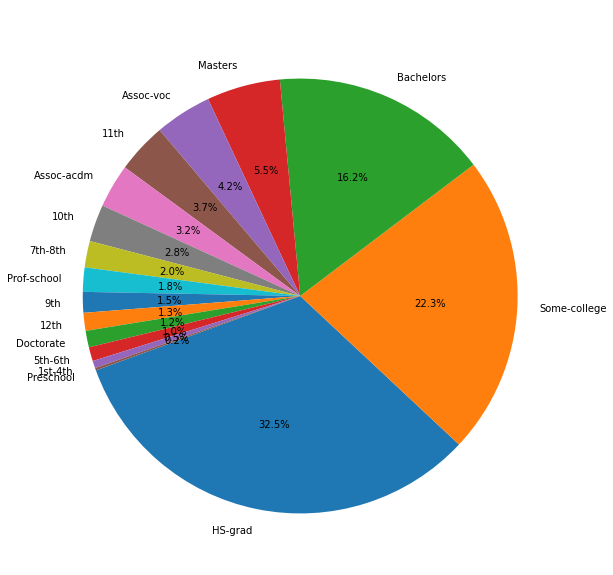

In [38]:
#Education categories
plt.figure(figsize=(10,10))
temp_series = train_data['education'].value_counts()
labels = (np.array(temp_series.index))
sizes = (np.array((temp_series / temp_series.sum())*100))
plt.pie(sizes, labels=labels, 
        autopct='%1.1f%%', startangle=200)
plt.title("Education", fontsize=15,color="w")
plt.savefig('Pie-chart')
plt.show()

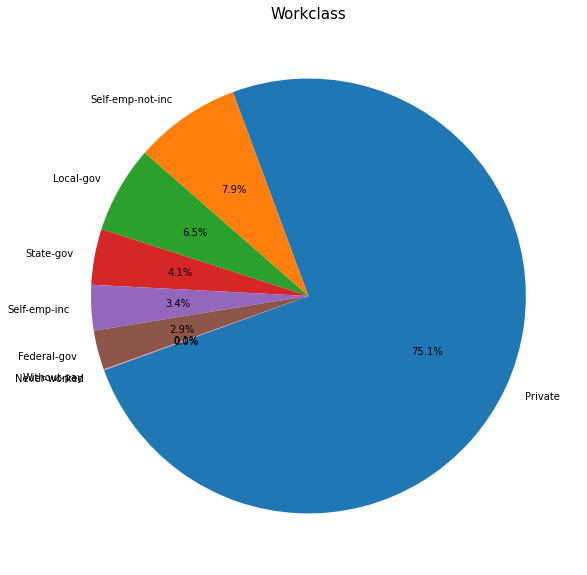

In [39]:
#Workclass Categories
plt.figure(figsize=(10,10))
temp_series = train_data['workclass'].value_counts()
labels = (np.array(temp_series.index))
sizes = (np.array((temp_series / temp_series.sum())*100))
plt.pie(sizes, labels=labels, 
        autopct='%1.1f%%', startangle=200)
plt.title("Workclass", fontsize=15,color="k")
plt.savefig('Pie-chart')
plt.show()

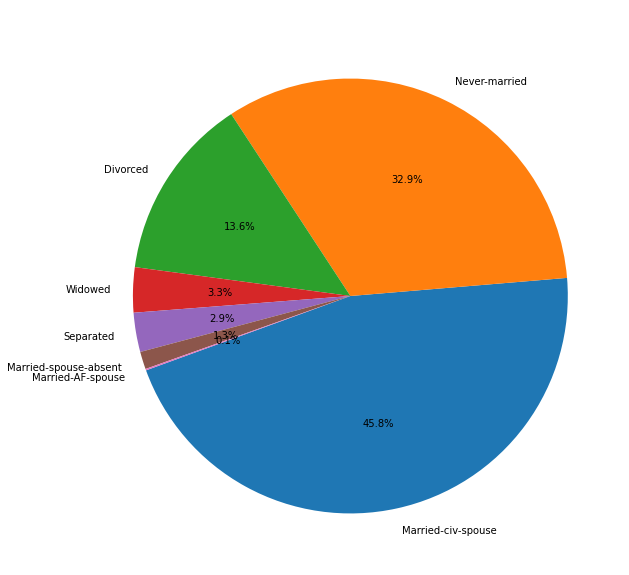

In [40]:
#Martial Status
plt.figure(figsize=(10,10))
temp_series = train_data['marital.status'].value_counts()
labels = (np.array(temp_series.index))
sizes = (np.array((temp_series / temp_series.sum())*100))
plt.pie(sizes, labels=labels, 
        autopct='%1.1f%%', startangle=200)
plt.title("marital-status", fontsize=15,color="w")
plt.savefig('Pie-chart')
plt.show()

Histogram of every numerical column


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb69c503940>,
      dtype=object)

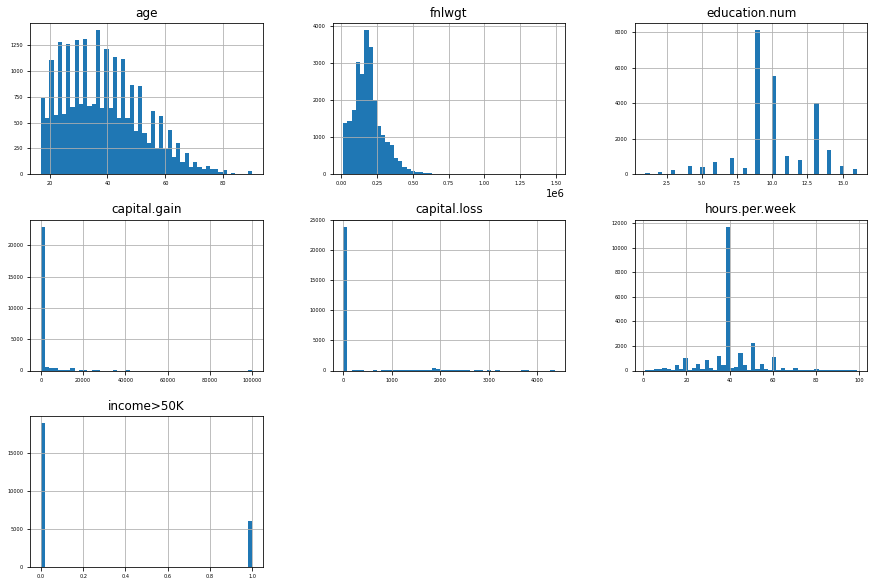

In [41]:
train_data.hist(figsize=(15,10), bins=50, xlabelsize=5, ylabelsize=5)

Distribution of education income wise

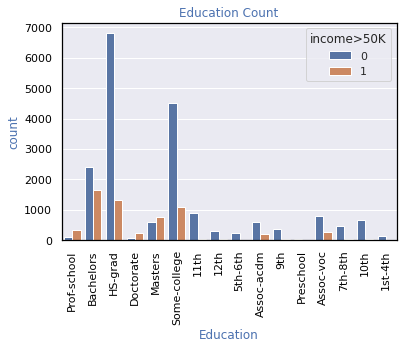

In [42]:
import seaborn as sns   
sns.set(color_codes=True)

with plt.rc_context({'axes.edgecolor':'black', 'xtick.color':'black', 'ytick.color':'black'}):
  scatplot = sns.countplot(x="education",hue="income>50K", data=train_data)

  plt.xlabel('Education',color="b")
  plt.ylabel('count',color="b")
  plt.xticks(rotation=90)
  plt.title('Education Count',color="b")
  plt.show()

## Split data
Tried to drop fnlwgt column - decreases the score

In [43]:
# Separating features and target variables for training data
X_train = train_data[['age', 'workclass', 'fnlwgt', 'education', 'education.num', 'marital.status', 'occupation', 'relationship', 'race', 'sex', 'capital.gain', 'capital.loss', 'hours.per.week', 'native.country']]
y_train = train_data['income>50K']

In [44]:
# Separate useful features for testing data (remove ID col)
X_test = test_data[['age', 'workclass', 'fnlwgt', 'education', 'education.num', 'marital.status', 'occupation', 'relationship', 'race', 'sex', 'capital.gain', 'capital.loss', 'hours.per.week', 'native.country']]

## Feature Engineering - Dealing with Categorical variables
Using Category Encoders

In [45]:
# Importing the category Encoders
! pip install category_encoders
import category_encoders as ce

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [46]:
# Check training data before encoding

X_train.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country
0,53,Self-emp-not-inc,93449,Prof-school,15,Married-civ-spouse,Prof-specialty,Husband,Asian-Pac-Islander,Male,0,0,40,India
1,33,Self-emp-not-inc,123424,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,40,United-States
2,47,Private,144844,HS-grad,9,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,40,United-States
3,40,Private,114580,HS-grad,9,Divorced,Craft-repair,Other-relative,White,Female,0,0,40,Vietnam
4,39,Private,115618,HS-grad,9,Married-civ-spouse,Transport-moving,Husband,White,Male,0,0,50,United-States


In [47]:
# Check testing data before encoding

X_test.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country
0,33,Self-emp-not-inc,222162,HS-grad,9,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,40,United-States
1,68,Private,29240,HS-grad,9,Widowed,Prof-specialty,Not-in-family,White,Female,0,0,12,United-States
2,34,Private,103596,HS-grad,9,Married-civ-spouse,Handlers-cleaners,Husband,White,Male,0,0,40,United-States
3,57,Private,103403,5th-6th,3,Married-civ-spouse,Transport-moving,Husband,White,Male,0,0,40,United-States
4,48,Private,152915,Some-college,10,Never-married,Adm-clerical,Not-in-family,White,Female,0,0,40,United-States


In [48]:
# Categorical Encoding for Categorical columns

encoder = ce.OrdinalEncoder(cols=['workclass','education','marital.status','occupation','relationship','race','sex','native.country'])

X_train = encoder.fit_transform(X_train)
X_test = encoder.transform(X_test)

In [49]:
# Check training data after encoding

X_train.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country
0,53,1,93449,1,15,1,1,1,1,1,0,0,40,1
1,33,1,123424,2,13,1,2,1,2,1,0,0,40,2
2,47,2,144844,3,9,1,3,1,2,1,0,0,40,2
3,40,2,114580,3,9,2,3,2,2,2,0,0,40,3
4,39,2,115618,3,9,1,4,1,2,1,0,0,50,2


In [50]:
# Check testing data after encoding

X_test.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country
0,33,1,222162,3,9,1,3,1,2,1,0,0,40,2.0
1,68,2,29240,3,9,5,1,4,2,2,0,0,12,2.0
2,34,2,103596,3,9,1,9,1,2,1,0,0,40,2.0
3,57,2,103403,9,3,1,4,1,2,1,0,0,40,2.0
4,48,2,152915,6,10,3,7,4,2,2,0,0,40,2.0


# Logistic Regression

In [51]:
# Make copies of train and test data

X_train_lr = X_train.copy()
y_train_lr = y_train.copy()
X_test_lr = X_test.copy()

In [52]:
# Standardization

from sklearn.preprocessing import StandardScaler

sc = StandardScaler()

X_train_lr = sc.fit_transform(X_train_lr)
X_test_lr = sc.transform(X_test_lr)

In [53]:
# Importing the required Libraries

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

In [54]:
# Defining model

lr = LogisticRegression()
lr.fit(X_train_lr, y_train_lr)

LogisticRegression()

In [55]:
# Predicting the values for x-test

y_pred_lr = lr.predict_proba(X_test_lr)

 ## Excel file for Log Reg

In [56]:
# Check what is in y_pred (because we have used predict_proba (gives probability) instead of predict (gives binary values))

for y in range(10):
  print(y_pred_lr[y])

# pred_y is in the form [Probability of prediction being 0, Probability of prediction being 1]

[0.81212101 0.18787899]
[0.99586377 0.00413623]
[0.84487384 0.15512616]
[0.94511532 0.05488468]
[0.9597267 0.0402733]
[0.99842214 0.00157786]
[0.94902582 0.05097418]
[0.66663774 0.33336226]
[0.450791 0.549209]
[0.28017756 0.71982244]


In [57]:
# Just checking shape

y_pred_lr.shape

(23842, 2)

In [58]:
test_data_lr = test_data.copy()

In [59]:
# Check Test Data before adding Predictions

test_data_lr.head()

,ID,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country
0,1,33,Self-emp-not-inc,222162,HS-grad,9,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,40,United-States
1,2,68,Private,29240,HS-grad,9,Widowed,Prof-specialty,Not-in-family,White,Female,0,0,12,United-States
2,3,34,Private,103596,HS-grad,9,Married-civ-spouse,Handlers-cleaners,Husband,White,Male,0,0,40,United-States
3,4,57,Private,103403,5th-6th,3,Married-civ-spouse,Transport-moving,Husband,White,Male,0,0,40,United-States
4,5,48,Private,152915,Some-college,10,Never-married,Adm-clerical,Not-in-family,White,Female,0,0,40,United-States


In [60]:
# Make an array with probabilities of prediction being 1 to add y_pred as a column

y_pred_lr_1 = []
for i in range(23842):
  y_pred_lr_1.append(y_pred_lr[i][1]) # we only need the probabilities of prediction being 1 since 0:Income<0 and 1:Income>=0 and we have to find Income>=0

In [61]:
# Just checking y_pred_1

for y in range(10):
  print(y_pred_lr_1[y])

0.1878789912084613
0.004136228079200974
0.15512615930286422
0.0548846775069424
0.040273300475949673
0.001577858653509889
0.050974176335135075
0.33336226415216785
0.5492090045061978
0.7198224395480429


In [62]:
# Add y_pred_1 as column 'Predictions' in test_data

test_data_lr['Prediction'] = y_pred_lr_1

In [63]:
# Check if Predictions column has been added to test_data

test_data_lr.head()

,ID,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,Prediction
0,1,33,Self-emp-not-inc,222162,HS-grad,9,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,40,United-States,0.187879
1,2,68,Private,29240,HS-grad,9,Widowed,Prof-specialty,Not-in-family,White,Female,0,0,12,United-States,0.004136
2,3,34,Private,103596,HS-grad,9,Married-civ-spouse,Handlers-cleaners,Husband,White,Male,0,0,40,United-States,0.155126
3,4,57,Private,103403,5th-6th,3,Married-civ-spouse,Transport-moving,Husband,White,Male,0,0,40,United-States,0.054885
4,5,48,Private,152915,Some-college,10,Never-married,Adm-clerical,Not-in-family,White,Female,0,0,40,United-States,0.040273


In [64]:
# Convert ID and Predictions to excel file

output = test_data_lr[['ID', 'Prediction']]
output.to_csv('ILP_LogReg.csv', index=0)
output

,ID,Prediction
0,1,0.187879
1,2,0.004136
2,3,0.155126
3,4,0.054885
4,5,0.040273
...,...,...
23837,23838,0.418963
23838,23839,0.071613
23839,23840,0.997827
23840,23841,0.229273


# Random Forest

In [65]:
# Make copies of train and test data

X_train_rf = X_train.copy()
y_train_rf = y_train.copy()
X_test_rf = X_test.copy()

In [66]:
# Importing the required libraries

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

In [67]:
# Defining Model

rf = RandomForestClassifier()
rf.fit(X_train_rf, y_train_rf)

RandomForestClassifier()

In [68]:
# Predicting the Probability of value for X_test

y_pred_rf = rf.predict_proba(X_test_rf)

## Excel File for Random Forest

In [69]:
# Check what is in y_pred (because we have used predict_proba (gives probability) instead of predict (gives binary values))

for y in range(10):
  print(y_pred_rf[y])

# pred_y is in the form [Probability of prediction being 0, Probability of prediction being 1]

[0.93 0.07]
[1. 0.]
[0.89 0.11]
[0.89 0.11]
[0.97 0.03]
[0.95 0.05]
[1. 0.]
[0.52 0.48]
[0.68 0.32]
[0.2 0.8]


In [70]:
# Just checking shape

y_pred_rf.shape

(23842, 2)

In [71]:
# Check Test Data before adding Predictions
test_data_rf = test_data.copy()
test_data_rf.head()

,ID,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country
0,1,33,Self-emp-not-inc,222162,HS-grad,9,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,40,United-States
1,2,68,Private,29240,HS-grad,9,Widowed,Prof-specialty,Not-in-family,White,Female,0,0,12,United-States
2,3,34,Private,103596,HS-grad,9,Married-civ-spouse,Handlers-cleaners,Husband,White,Male,0,0,40,United-States
3,4,57,Private,103403,5th-6th,3,Married-civ-spouse,Transport-moving,Husband,White,Male,0,0,40,United-States
4,5,48,Private,152915,Some-college,10,Never-married,Adm-clerical,Not-in-family,White,Female,0,0,40,United-States


In [72]:
# Make an array with probabilities of prediction being 1 to add y_pred as a column

y_pred_rf_1 = []
for i in range(23842):
  y_pred_rf_1.append(y_pred_rf[i][1]) # we only need the probabilities of prediction being 1 since 0:Income<0 and 1:Income>=0 and we have to find Income>=0

In [73]:
# Just checking y_pred_1

for y in range(10):
  print(y_pred_rf_1[y])

0.07
0.0
0.11
0.11
0.03
0.05
0.0
0.48
0.32
0.8


In [74]:
# Add y_pred_1 as column 'Predictions' in test_data

test_data_rf['Prediction'] = y_pred_rf_1

In [75]:
# Check if Predictions column has been added to test_data

test_data_rf.head()

,ID,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,Prediction
0,1,33,Self-emp-not-inc,222162,HS-grad,9,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,40,United-States,0.07
1,2,68,Private,29240,HS-grad,9,Widowed,Prof-specialty,Not-in-family,White,Female,0,0,12,United-States,0.00
2,3,34,Private,103596,HS-grad,9,Married-civ-spouse,Handlers-cleaners,Husband,White,Male,0,0,40,United-States,0.11
3,4,57,Private,103403,5th-6th,3,Married-civ-spouse,Transport-moving,Husband,White,Male,0,0,40,United-States,0.11
4,5,48,Private,152915,Some-college,10,Never-married,Adm-clerical,Not-in-family,White,Female,0,0,40,United-States,0.03


In [76]:
# Convert ID and Predictions to excel file

output = test_data_rf[['ID', 'Prediction']]
output.to_csv('ILP_RandFor.csv', index=0)
output

,ID,Prediction
0,1,0.07
1,2,0.00
2,3,0.11
3,4,0.11
4,5,0.03
...,...,...
23837,23838,0.19
23838,23839,0.01
23839,23840,0.91
23840,23841,0.20


# Decision Tree

In [77]:
# Make copies of train and test data

X_train_dt = X_train.copy()
y_train_dt = y_train.copy()
X_test_dt = X_test.copy()

In [78]:
# Importing DecisionTreeClassifier

from sklearn.tree import DecisionTreeClassifier

In [79]:
# Defining Model

dt = DecisionTreeClassifier(criterion="entropy", max_depth=3, random_state=0)

In [80]:
# Fitting/Training the Model

dt.fit(X_train_dt, y_train_dt)

DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=0)

In [81]:
# Prediction Probability

y_pred_dt = dt.predict_proba(X_test_dt)

## Excel File for Decision Trees

In [82]:
# Check what is in y_pred (because we have used predict_proba (gives probability) instead of predict (gives binary values))

for y in range(10):
  print(y_pred_dt[y])

# pred_y is in the form [Probability of prediction being 0, Probability of prediction being 1]

[0.70345727 0.29654273]
[0.97440465 0.02559535]
[0.70345727 0.29654273]
[0.70345727 0.29654273]
[0.97440465 0.02559535]
[0.97440465 0.02559535]
[0.97440465 0.02559535]
[0.70345727 0.29654273]
[0.70345727 0.29654273]
[0.33204904 0.66795096]


In [83]:
# Just checking shape

y_pred_dt.shape

(23842, 2)

In [84]:
# Check Test Data before adding Predictions
test_data_dt = test_data.copy()
test_data_dt.head()

,ID,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country
0,1,33,Self-emp-not-inc,222162,HS-grad,9,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,40,United-States
1,2,68,Private,29240,HS-grad,9,Widowed,Prof-specialty,Not-in-family,White,Female,0,0,12,United-States
2,3,34,Private,103596,HS-grad,9,Married-civ-spouse,Handlers-cleaners,Husband,White,Male,0,0,40,United-States
3,4,57,Private,103403,5th-6th,3,Married-civ-spouse,Transport-moving,Husband,White,Male,0,0,40,United-States
4,5,48,Private,152915,Some-college,10,Never-married,Adm-clerical,Not-in-family,White,Female,0,0,40,United-States


In [85]:
# Make an array with probabilities of prediction being 1 to add y_pred as a column

y_pred_dt_1 = []
for i in range(23842):
  y_pred_dt_1.append(y_pred_dt[i][1]) # we only need the probabilities of prediction being 1 since 0:Income<0 and 1:Income>=0 and we have to find Income>=0

In [86]:
# Just checking y_pred_1

for y in range(10):
  print(y_pred_dt_1[y])

0.296542726679713
0.025595349709356834
0.296542726679713
0.296542726679713
0.025595349709356834
0.025595349709356834
0.025595349709356834
0.296542726679713
0.296542726679713
0.6679509632224168


In [87]:
# Add y_pred_1 as column 'Predictions' in test_data

test_data_dt['Prediction'] = y_pred_dt_1

In [88]:
# Check if Predictions column has been added to test_data

test_data_dt.head()

,ID,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,Prediction
0,1,33,Self-emp-not-inc,222162,HS-grad,9,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,40,United-States,0.296543
1,2,68,Private,29240,HS-grad,9,Widowed,Prof-specialty,Not-in-family,White,Female,0,0,12,United-States,0.025595
2,3,34,Private,103596,HS-grad,9,Married-civ-spouse,Handlers-cleaners,Husband,White,Male,0,0,40,United-States,0.296543
3,4,57,Private,103403,5th-6th,3,Married-civ-spouse,Transport-moving,Husband,White,Male,0,0,40,United-States,0.296543
4,5,48,Private,152915,Some-college,10,Never-married,Adm-clerical,Not-in-family,White,Female,0,0,40,United-States,0.025595


In [89]:
# Convert ID and Predictions to excel file

output = test_data_dt[['ID', 'Prediction']]
output.to_csv('ILP_DecTree.csv', index=0)
output

,ID,Prediction
0,1,0.296543
1,2,0.025595
2,3,0.296543
3,4,0.296543
4,5,0.025595
...,...,...
23837,23838,0.667951
23838,23839,0.153904
23839,23840,0.882353
23840,23841,0.025595


# Naive Bayes

In [90]:
# Make copies of train and test data

X_train_nb = X_train.copy()
y_train_nb = y_train.copy()
X_test_nb = X_test.copy()

In [91]:
from sklearn.preprocessing import MinMaxScaler #fixed import

scaler = MinMaxScaler()
X_train_nb = scaler.fit_transform(X_train_nb)
X_test_nb = scaler.transform(X_test_nb)

In [92]:
# Importing Categorical NB

from sklearn.naive_bayes import CategoricalNB

In [93]:
# Fitting/Training the Model

mnb = CategoricalNB().fit(X_train_nb, y_train_nb)

In [94]:
# Prediction Probability

y_pred_nb = mnb.predict_proba(X_test_nb)

In [95]:
# Check what is in y_pred (because we have used predict_proba (gives probability) instead of predict (gives binary values))

for y in range(10):
  print(y_pred_nb[y])

# pred_y is in the form [Probability of prediction being 0, Probability of prediction being 1]

[0.71696502 0.28303498]
[0.90085517 0.09914483]
[0.71696502 0.28303498]
[0.71696502 0.28303498]
[0.90085517 0.09914483]
[0.90085517 0.09914483]
[0.90085517 0.09914483]
[0.71696502 0.28303498]
[0.71696502 0.28303498]
[0.71696502 0.28303498]


In [96]:
# Just checking shape

y_pred_nb.shape

(23842, 2)

In [97]:
# Check Test Data before adding Predictions
test_data_nb = test_data.copy()
test_data_nb.head()

,ID,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country
0,1,33,Self-emp-not-inc,222162,HS-grad,9,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,40,United-States
1,2,68,Private,29240,HS-grad,9,Widowed,Prof-specialty,Not-in-family,White,Female,0,0,12,United-States
2,3,34,Private,103596,HS-grad,9,Married-civ-spouse,Handlers-cleaners,Husband,White,Male,0,0,40,United-States
3,4,57,Private,103403,5th-6th,3,Married-civ-spouse,Transport-moving,Husband,White,Male,0,0,40,United-States
4,5,48,Private,152915,Some-college,10,Never-married,Adm-clerical,Not-in-family,White,Female,0,0,40,United-States


In [98]:
# Make an array with probabilities of prediction being 1 to add y_pred as a column

y_pred_nb_1 = []
for i in range(23842):
  y_pred_nb_1.append(y_pred_nb[i][1]) # we only need the probabilities of prediction being 1 since 0:Income<0 and 1:Income>=0 and we have to find Income>=0

In [99]:
# Just checking y_pred_1

for y in range(10):
  print(y_pred_nb_1[y])

0.28303497663839466
0.09914483405825025
0.28303497663839466
0.28303497663839466
0.09914483405825025
0.09914483405825025
0.09914483405825025
0.28303497663839466
0.28303497663839466
0.28303497663839466


In [100]:
# Add y_pred_1 as column 'Predictions' in test_data

test_data_nb['Prediction'] = y_pred_nb_1

In [101]:
# Check if Predictions column has been added to test_data

test_data_nb.head()

,ID,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,Prediction
0,1,33,Self-emp-not-inc,222162,HS-grad,9,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,40,United-States,0.283035
1,2,68,Private,29240,HS-grad,9,Widowed,Prof-specialty,Not-in-family,White,Female,0,0,12,United-States,0.099145
2,3,34,Private,103596,HS-grad,9,Married-civ-spouse,Handlers-cleaners,Husband,White,Male,0,0,40,United-States,0.283035
3,4,57,Private,103403,5th-6th,3,Married-civ-spouse,Transport-moving,Husband,White,Male,0,0,40,United-States,0.283035
4,5,48,Private,152915,Some-college,10,Never-married,Adm-clerical,Not-in-family,White,Female,0,0,40,United-States,0.099145


In [102]:
# Convert ID and Predictions to excel file

output = test_data_nb[['ID', 'Prediction']]
output.to_csv('ILP_NaiveBayes.csv', index=0)
output

,ID,Prediction
0,1,0.283035
1,2,0.099145
2,3,0.283035
3,4,0.283035
4,5,0.099145
...,...,...
23837,23838,0.283035
23838,23839,0.099145
23839,23840,0.283035
23840,23841,0.283035


# K Neighbors Classifier

In [103]:
# Make copies of train and test data

X_train_kn = X_train.copy()
y_train_kn = y_train.copy()
X_test_kn = X_test.copy()

In [104]:
# Importing Categorical NB

from sklearn.neighbors import KNeighborsClassifier

In [105]:
# Fitting/Training the Model

kn = KNeighborsClassifier(n_neighbors = 5).fit(X_train_kn, y_train_kn)

In [106]:
# Prediction Probability

y_pred_kn = kn.predict_proba(X_test_kn)

In [107]:
# Check what is in y_pred (because we have used predict_proba (gives probability) instead of predict (gives binary values))

for y in range(10):
  print(y_pred_kn[y])

# pred_y is in the form [Probability of prediction being 0, Probability of prediction being 1]

[0.8 0.2]
[0.8 0.2]
[0.8 0.2]
[0.8 0.2]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[0.8 0.2]
[0.8 0.2]


In [108]:
# Just checking shape

y_pred_kn.shape

(23842, 2)

In [109]:
# Check Test Data before adding Predictions
test_data_kn = test_data.copy()
test_data_kn.head()

,ID,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country
0,1,33,Self-emp-not-inc,222162,HS-grad,9,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,40,United-States
1,2,68,Private,29240,HS-grad,9,Widowed,Prof-specialty,Not-in-family,White,Female,0,0,12,United-States
2,3,34,Private,103596,HS-grad,9,Married-civ-spouse,Handlers-cleaners,Husband,White,Male,0,0,40,United-States
3,4,57,Private,103403,5th-6th,3,Married-civ-spouse,Transport-moving,Husband,White,Male,0,0,40,United-States
4,5,48,Private,152915,Some-college,10,Never-married,Adm-clerical,Not-in-family,White,Female,0,0,40,United-States


In [110]:
# Make an array with probabilities of prediction being 1 to add y_pred as a column

y_pred_kn_1 = []
for i in range(23842):
  y_pred_kn_1.append(y_pred_kn[i][1]) # we only need the probabilities of prediction being 1 since 0:Income<0 and 1:Income>=0 and we have to find Income>=0

In [111]:
# Just checking y_pred_1

for y in range(10):
  print(y_pred_kn_1[y])

0.2
0.2
0.2
0.2
0.0
0.0
0.0
0.0
0.2
0.2


In [112]:
# Add y_pred_1 as column 'Predictions' in test_data

test_data_kn['Prediction'] = y_pred_kn_1

In [113]:
# Check if Predictions column has been added to test_data

test_data_kn.head()

,ID,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,Prediction
0,1,33,Self-emp-not-inc,222162,HS-grad,9,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,40,United-States,0.2
1,2,68,Private,29240,HS-grad,9,Widowed,Prof-specialty,Not-in-family,White,Female,0,0,12,United-States,0.2
2,3,34,Private,103596,HS-grad,9,Married-civ-spouse,Handlers-cleaners,Husband,White,Male,0,0,40,United-States,0.2
3,4,57,Private,103403,5th-6th,3,Married-civ-spouse,Transport-moving,Husband,White,Male,0,0,40,United-States,0.2
4,5,48,Private,152915,Some-college,10,Never-married,Adm-clerical,Not-in-family,White,Female,0,0,40,United-States,0.0


In [114]:
# Convert ID and Predictions to excel file

output = test_data_kn[['ID', 'Prediction']]
output.to_csv('ILP_KNeighbors.csv', index=0)
output

,ID,Prediction
0,1,0.2
1,2,0.2
2,3,0.2
3,4,0.2
4,5,0.0
...,...,...
23837,23838,0.6
23838,23839,0.2
23839,23840,1.0
23840,23841,0.0


# Support Vector Machine

In [115]:
# Make copies of train and test data

X_train_svm = X_train.copy()
y_train_svm = y_train.copy()
X_test_svm = X_test.copy()

In [116]:
# Importing the required libraries

from sklearn.svm import SVC

In [117]:
# Defining Model

svm=SVC(C=0.0001, probability=True)
svm.fit(X_train_svm, y_train_svm)

SVC(C=0.0001, probability=True)

In [118]:
# Predicting the Probability of value for X_test

y_pred_svm = svm.predict_proba(X_test_svm)

In [119]:
# Check what is in y_pred (because we have used predict_proba (gives probability) instead of predict (gives binary values))

for y in range(10):
  print(y_pred_svm[y])

# pred_y is in the form [Probability of prediction being 0, Probability of prediction being 1]

[0.62387209 0.37612791]
[0.63510855 0.36489145]
[0.62894559 0.37105441]
[0.62897106 0.37102894]
[0.62358738 0.37641262]
[0.62257617 0.37742383]
[0.62365018 0.37634982]
[0.62244544 0.37755456]
[0.63198899 0.36801101]
[0.64190871 0.35809129]


In [120]:
# Just checking shape

y_pred_svm.shape

(23842, 2)

In [121]:
# Check Test Data before adding Predictions
test_data_svm = test_data.copy()
test_data_svm.head()

,ID,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country
0,1,33,Self-emp-not-inc,222162,HS-grad,9,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,40,United-States
1,2,68,Private,29240,HS-grad,9,Widowed,Prof-specialty,Not-in-family,White,Female,0,0,12,United-States
2,3,34,Private,103596,HS-grad,9,Married-civ-spouse,Handlers-cleaners,Husband,White,Male,0,0,40,United-States
3,4,57,Private,103403,5th-6th,3,Married-civ-spouse,Transport-moving,Husband,White,Male,0,0,40,United-States
4,5,48,Private,152915,Some-college,10,Never-married,Adm-clerical,Not-in-family,White,Female,0,0,40,United-States


In [122]:
# Make an array with probabilities of prediction being 1 to add y_pred as a column

y_pred_svm_1 = []
for i in range(23842):
  y_pred_svm_1.append(y_pred_svm[i][1]) # we only need the probabilities of prediction being 1 since 0:Income<0 and 1:Income>=0 and we have to find Income>=0

In [123]:
# Just checking y_pred_1

for y in range(10):
  print(y_pred_svm_1[y])

0.37612791219288816
0.36489145191020517
0.37105440607524326
0.37102893588447744
0.37641262091787947
0.377423832769121
0.37634982120691163
0.3775545579630402
0.368011011273713
0.35809129187251587


In [124]:
# Add y_pred_1 as column 'Predictions' in test_data

test_data_svm['Prediction'] = y_pred_svm_1

In [125]:
# Check if Predictions column has been added to test_data

test_data_svm.head()

,ID,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,Prediction
0,1,33,Self-emp-not-inc,222162,HS-grad,9,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,40,United-States,0.376128
1,2,68,Private,29240,HS-grad,9,Widowed,Prof-specialty,Not-in-family,White,Female,0,0,12,United-States,0.364891
2,3,34,Private,103596,HS-grad,9,Married-civ-spouse,Handlers-cleaners,Husband,White,Male,0,0,40,United-States,0.371054
3,4,57,Private,103403,5th-6th,3,Married-civ-spouse,Transport-moving,Husband,White,Male,0,0,40,United-States,0.371029
4,5,48,Private,152915,Some-college,10,Never-married,Adm-clerical,Not-in-family,White,Female,0,0,40,United-States,0.376413


In [126]:
# Convert ID and Predictions to excel file

output = test_data_svm[['ID', 'Prediction']]
output.to_csv('ILP_SVM.csv', index=0)
output

,ID,Prediction
0,1,0.376128
1,2,0.364891
2,3,0.371054
3,4,0.371029
4,5,0.376413
...,...,...
23837,23838,0.364930
23838,23839,0.372709
23839,23840,0.905066
23840,23841,0.369972


# Bagging Decision Tree

In [127]:
# Make copies of train and test data

X_train_bg = X_train.copy()
y_train_bg = y_train.copy()
X_test_bg = X_test.copy()

In [128]:
# Importing the required libraries

from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

In [129]:
# Defining model

# max_samples: maximum size 0.5=50% of each sample taken from the full dataset
# max_features: maximum of features 1=100% taken here all 10K 
# n_estimators: number of decision trees 
bg=BaggingClassifier(DecisionTreeClassifier(),max_samples=0.5,max_features=1.0,n_estimators=10)
bg.fit(X_train_bg, y_train_bg)


BaggingClassifier(base_estimator=DecisionTreeClassifier(), max_samples=0.5)

In [130]:
# Predicting the Probability of value for X_test

y_pred_bg = bg.predict_proba(X_test_bg)

In [131]:
# Check what is in y_pred (because we have used predict_proba (gives probability) instead of predict (gives binary values))

for y in range(10):
  print(y_pred_bg[y])

# pred_y is in the form [Probability of prediction being 0, Probability of prediction being 1]

[0.9 0.1]
[1. 0.]
[0.6 0.4]
[1. 0.]
[1. 0.]
[0.9 0.1]
[1. 0.]
[0.4 0.6]
[1. 0.]
[0.3 0.7]


In [132]:
# Just checking shape

y_pred_bg.shape

(23842, 2)

In [133]:
# Check Test Data before adding Predictions
test_data_bg = test_data.copy()
test_data_bg.head()

,ID,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country
0,1,33,Self-emp-not-inc,222162,HS-grad,9,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,40,United-States
1,2,68,Private,29240,HS-grad,9,Widowed,Prof-specialty,Not-in-family,White,Female,0,0,12,United-States
2,3,34,Private,103596,HS-grad,9,Married-civ-spouse,Handlers-cleaners,Husband,White,Male,0,0,40,United-States
3,4,57,Private,103403,5th-6th,3,Married-civ-spouse,Transport-moving,Husband,White,Male,0,0,40,United-States
4,5,48,Private,152915,Some-college,10,Never-married,Adm-clerical,Not-in-family,White,Female,0,0,40,United-States


In [134]:
# Make an array with probabilities of prediction being 1 to add y_pred as a column

y_pred_bg_1 = []
for i in range(23842):
  y_pred_bg_1.append(y_pred_bg[i][1]) # we only need the probabilities of prediction being 1 since 0:Income<0 and 1:Income>=0 and we have to find Income>=0

In [135]:
# Just checking y_pred_1

for y in range(10):
  print(y_pred_bg_1[y])

0.1
0.0
0.4
0.0
0.0
0.1
0.0
0.6
0.0
0.7


In [136]:
# Add y_pred_1 as column 'Predictions' in test_data

test_data_bg['Prediction'] = y_pred_bg_1

In [137]:
# Check if Predictions column has been added to test_data

test_data_bg.head()

,ID,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,Prediction
0,1,33,Self-emp-not-inc,222162,HS-grad,9,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,40,United-States,0.1
1,2,68,Private,29240,HS-grad,9,Widowed,Prof-specialty,Not-in-family,White,Female,0,0,12,United-States,0.0
2,3,34,Private,103596,HS-grad,9,Married-civ-spouse,Handlers-cleaners,Husband,White,Male,0,0,40,United-States,0.4
3,4,57,Private,103403,5th-6th,3,Married-civ-spouse,Transport-moving,Husband,White,Male,0,0,40,United-States,0.0
4,5,48,Private,152915,Some-college,10,Never-married,Adm-clerical,Not-in-family,White,Female,0,0,40,United-States,0.0


In [138]:
# Convert ID and Predictions to excel file

output = test_data_bg[['ID', 'Prediction']]
output.to_csv('ILP_bag.csv', index=0)
output

,ID,Prediction
0,1,0.1
1,2,0.0
2,3,0.4
3,4,0.0
4,5,0.0
...,...,...
23837,23838,0.2
23838,23839,0.0
23839,23840,1.0
23840,23841,0.1


# Boosted Decision Tree - AdaBoost

In [139]:
# Make copies of train and test data

X_train_adb = X_train.copy()
y_train_adb = y_train.copy()
X_test_adb = X_test.copy()

In [140]:
# Importing required libraries

from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

In [141]:
# Model Fitting

adb = AdaBoostClassifier(DecisionTreeClassifier(min_samples_split=10,max_depth=4),n_estimators=10,learning_rate=0.6)
adb.fit(X_train_adb, y_train_adb)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=4,
                                                         min_samples_split=10),
                   learning_rate=0.6, n_estimators=10)

In [142]:
# Predicting the Probability of value for X_test

y_pred_adb = adb.predict_proba(X_test_adb)

In [143]:
# Check what is in y_pred (because we have used predict_proba (gives probability) instead of predict (gives binary values))

for y in range(10):
  print(y_pred_adb[y])

# pred_y is in the form [Probability of prediction being 0, Probability of prediction being 1]

[0.55510407 0.44489593]
[0.65938869 0.34061131]
[0.57335789 0.42664211]
[0.63411317 0.36588683]
[0.61622315 0.38377685]
[0.66454145 0.33545855]
[0.754586 0.245414]
[0.50581956 0.49418044]
[0.9850196 0.0149804]
[0.4761737 0.5238263]


In [144]:
# Just checking shape

y_pred_adb.shape

(23842, 2)

In [145]:
# Check Test Data before adding Predictions
test_data_adb = test_data.copy()
test_data_adb.head()

,ID,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country
0,1,33,Self-emp-not-inc,222162,HS-grad,9,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,40,United-States
1,2,68,Private,29240,HS-grad,9,Widowed,Prof-specialty,Not-in-family,White,Female,0,0,12,United-States
2,3,34,Private,103596,HS-grad,9,Married-civ-spouse,Handlers-cleaners,Husband,White,Male,0,0,40,United-States
3,4,57,Private,103403,5th-6th,3,Married-civ-spouse,Transport-moving,Husband,White,Male,0,0,40,United-States
4,5,48,Private,152915,Some-college,10,Never-married,Adm-clerical,Not-in-family,White,Female,0,0,40,United-States


In [146]:
# Make an array with probabilities of prediction being 1 to add y_pred as a column

y_pred_adb_1 = []
for i in range(23842):
  y_pred_adb_1.append(y_pred_adb[i][1]) # we only need the probabilities of prediction being 1 since 0:Income<0 and 1:Income>=0 and we have to find Income>=0

In [147]:
# Just checking y_pred_1

for y in range(10):
  print(y_pred_adb_1[y])

0.444895931658217
0.3406113128949128
0.4266421135385845
0.36588683394437144
0.3837768490638751
0.33545854652783685
0.2454140045393258
0.4941804389606167
0.014980400477621511
0.5238262979622068


In [148]:
# Add y_pred_1 as column 'Predictions' in test_data

test_data_adb['Prediction'] = y_pred_adb_1

In [149]:
# Check if Predictions column has been added to test_data

test_data_adb.head()

,ID,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,Prediction
0,1,33,Self-emp-not-inc,222162,HS-grad,9,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,40,United-States,0.444896
1,2,68,Private,29240,HS-grad,9,Widowed,Prof-specialty,Not-in-family,White,Female,0,0,12,United-States,0.340611
2,3,34,Private,103596,HS-grad,9,Married-civ-spouse,Handlers-cleaners,Husband,White,Male,0,0,40,United-States,0.426642
3,4,57,Private,103403,5th-6th,3,Married-civ-spouse,Transport-moving,Husband,White,Male,0,0,40,United-States,0.365887
4,5,48,Private,152915,Some-college,10,Never-married,Adm-clerical,Not-in-family,White,Female,0,0,40,United-States,0.383777


In [150]:
# Convert ID and Predictions to excel file

output = test_data_adb[['ID', 'Prediction']]
output.to_csv('ILP_AdaBoost.csv', index=0)
output

,ID,Prediction
0,1,0.444896
1,2,0.340611
2,3,0.426642
3,4,0.365887
4,5,0.383777
...,...,...
23837,23838,0.472844
23838,23839,0.340803
23839,23840,0.716382
23840,23841,0.438873


# Boosted Decision Tree - XGBoost

In [151]:
# Make copies of train and test data

X_train_xgb = X_train.copy()
y_train_xgb = y_train.copy()
X_test_xgb = X_test.copy()

In [152]:
# Importing required libraries

from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeClassifier

In [153]:
# Model Fitting

xgb = XGBRegressor(
    n_estimators=100,
    reg_lambda=1,
    gamma=0,
    max_depth=3
)
xgb.fit(X_train_xgb, y_train_xgb)

[02:40:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor()

In [154]:
# Predicting the value for X_test

y_pred_xgb = xgb.predict(X_test_xgb)

In [155]:

for y in range(10):
  print(y_pred_xgb[y])

0.15911943
0.0070285797
0.15772
0.13388345
0.063646436
-0.003847301
-0.018602908
0.42637435
0.30407876
0.56508875


In [156]:
# Just checking shape

y_pred_xgb.shape

(23842,)

In [157]:
# Check Test Data before adding Predictions
test_data_xgb = test_data.copy()
test_data_xgb.head()

,ID,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country
0,1,33,Self-emp-not-inc,222162,HS-grad,9,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,40,United-States
1,2,68,Private,29240,HS-grad,9,Widowed,Prof-specialty,Not-in-family,White,Female,0,0,12,United-States
2,3,34,Private,103596,HS-grad,9,Married-civ-spouse,Handlers-cleaners,Husband,White,Male,0,0,40,United-States
3,4,57,Private,103403,5th-6th,3,Married-civ-spouse,Transport-moving,Husband,White,Male,0,0,40,United-States
4,5,48,Private,152915,Some-college,10,Never-married,Adm-clerical,Not-in-family,White,Female,0,0,40,United-States


In [158]:
# Add y_pred_1 as column 'Predictions' in test_data

test_data_xgb['Prediction'] = y_pred_xgb

In [159]:
# Check if Predictions column has been added to test_data

test_data_xgb.head()

,ID,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,Prediction
0,1,33,Self-emp-not-inc,222162,HS-grad,9,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,40,United-States,0.159119
1,2,68,Private,29240,HS-grad,9,Widowed,Prof-specialty,Not-in-family,White,Female,0,0,12,United-States,0.007029
2,3,34,Private,103596,HS-grad,9,Married-civ-spouse,Handlers-cleaners,Husband,White,Male,0,0,40,United-States,0.157720
3,4,57,Private,103403,5th-6th,3,Married-civ-spouse,Transport-moving,Husband,White,Male,0,0,40,United-States,0.133883
4,5,48,Private,152915,Some-college,10,Never-married,Adm-clerical,Not-in-family,White,Female,0,0,40,United-States,0.063646


In [160]:
# Convert ID and Predictions to excel file

output = test_data_xgb[['ID', 'Prediction']]
output.to_csv('ILP_XGBoost.csv', index=0)
output

,ID,Prediction
0,1,0.159119
1,2,0.007029
2,3,0.157720
3,4,0.133883
4,5,0.063646
...,...,...
23837,23838,0.385093
23838,23839,0.008254
23839,23840,0.829505
23840,23841,0.140408


# Boosted Decision Tree - Grad Boost

In [161]:
# Make copies of train and test data

X_train_gb = X_train.copy()
y_train_gb = y_train.copy()
X_test_gb = X_test.copy()

In [162]:
# Importing required libraries

from sklearn.ensemble import GradientBoostingClassifier #For Classificationfrom sklearn.tree import DecisionTreeClassifier

In [163]:
# Model Fitting

gb = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1)
gb.fit(X_train_gb, y_train_gb)

GradientBoostingClassifier(learning_rate=1.0, max_depth=1)

In [164]:
# Predicting the Probability of value for X_test

y_pred_gb = gb.predict_proba(X_test_gb)

In [165]:
# Check what is in y_pred (because we have used predict_proba (gives probability) instead of predict (gives binary values))

for y in range(10):
  print(y_pred_gb[y])

# pred_y is in the form [Probability of prediction being 0, Probability of prediction being 1]

[0.8691954 0.1308046]
[0.98546952 0.01453048]
[0.87218944 0.12781056]
[0.89658373 0.10341627]
[0.94673448 0.05326552]
[0.97711336 0.02288664]
[0.98952559 0.01047441]
[0.54888235 0.45111765]
[0.85719995 0.14280005]
[0.40685889 0.59314111]


In [166]:
# Just checking shape

y_pred_gb.shape

(23842, 2)

In [167]:
# Check Test Data before adding Predictions
test_data_gb = test_data.copy()
test_data_gb.head()

,ID,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country
0,1,33,Self-emp-not-inc,222162,HS-grad,9,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,40,United-States
1,2,68,Private,29240,HS-grad,9,Widowed,Prof-specialty,Not-in-family,White,Female,0,0,12,United-States
2,3,34,Private,103596,HS-grad,9,Married-civ-spouse,Handlers-cleaners,Husband,White,Male,0,0,40,United-States
3,4,57,Private,103403,5th-6th,3,Married-civ-spouse,Transport-moving,Husband,White,Male,0,0,40,United-States
4,5,48,Private,152915,Some-college,10,Never-married,Adm-clerical,Not-in-family,White,Female,0,0,40,United-States


In [168]:
# Make an array with probabilities of prediction being 1 to add y_pred as a column

y_pred_gb_1 = []
for i in range(23842):
  y_pred_gb_1.append(y_pred_gb[i][1]) # we only need the probabilities of prediction being 1 since 0:Income<0 and 1:Income>=0 and we have to find Income>=0

In [169]:
# Just checking y_pred_1

for y in range(10):
  print(y_pred_gb_1[y])

0.13080460241439434
0.014530475186275576
0.12781056113547293
0.10341627052362724
0.05326552041056005
0.02288663601361637
0.010474413378034824
0.4511176489371727
0.1428000515847888
0.593141112941208


In [170]:
# Add y_pred_1 as column 'Predictions' in test_data

test_data_gb['Prediction'] = y_pred_gb_1

In [171]:
# Check if Predictions column has been added to test_data

test_data_gb.head()

,ID,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,Prediction
0,1,33,Self-emp-not-inc,222162,HS-grad,9,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,40,United-States,0.130805
1,2,68,Private,29240,HS-grad,9,Widowed,Prof-specialty,Not-in-family,White,Female,0,0,12,United-States,0.014530
2,3,34,Private,103596,HS-grad,9,Married-civ-spouse,Handlers-cleaners,Husband,White,Male,0,0,40,United-States,0.127811
3,4,57,Private,103403,5th-6th,3,Married-civ-spouse,Transport-moving,Husband,White,Male,0,0,40,United-States,0.103416
4,5,48,Private,152915,Some-college,10,Never-married,Adm-clerical,Not-in-family,White,Female,0,0,40,United-States,0.053266


In [172]:
# Convert ID and Predictions to excel file

output = test_data_gb[['ID', 'Prediction']]
output.to_csv('ILP_GradBoost.csv', index=0)
output

,ID,Prediction
0,1,0.130805
1,2,0.014530
2,3,0.127811
3,4,0.103416
4,5,0.053266
...,...,...
23837,23838,0.262099
23838,23839,0.033513
23839,23840,0.989065
23840,23841,0.127610


# Voting Classification

In [173]:
# Make copies of train and test data

X_train_vc = X_train.copy()
y_train_vc = y_train.copy()
X_test_vc = X_test.copy()

In [174]:
from sklearn.ensemble import VotingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [175]:
mnb = MultinomialNB()
mnb.fit(X_train_vc, y_train_vc)

MultinomialNB()

In [176]:
lr = LogisticRegression()
lr.fit(X_train_vc, y_train_vc)

LogisticRegression()

In [177]:
rf = RandomForestClassifier()
rf.fit(X_train_vc, y_train_vc)

RandomForestClassifier()

In [178]:
svm=SVC(C=0.0001, probability=True)
svm.fit(X_train_vc, y_train_vc)

SVC(C=0.0001, probability=True)

In [179]:
# 1) naive bias = mnb
# 2) logistic regression =lr
# 3) random forest =rf
# 4) support vector machine = svm
evc=VotingClassifier(estimators=[('mnb',mnb),('lr',lr),('rf',rf),('svm',svm)],voting='soft')
evc.fit(X_train_vc, y_train_vc)


VotingClassifier(estimators=[('mnb', MultinomialNB()),
                             ('lr', LogisticRegression()),
                             ('rf', RandomForestClassifier()),
                             ('svm', SVC(C=0.0001, probability=True))],
                 voting='soft')

In [180]:
# Predicting the Probability of value for X_test

y_pred_vc = evc.predict_proba(X_test_vc)

In [181]:
# Check what is in y_pred (because we have used predict_proba (gives probability) instead of predict (gives binary values))

for y in range(10):
  print(y_pred_vc[y])

# pred_y is in the form [Probability of prediction being 0, Probability of prediction being 1]

[0.82899373 0.17100627]
[0.83203171 0.16796829]
[0.82039169 0.17960831]
[0.81413474 0.18586526]
[0.84951921 0.15048079]
[0.83975562 0.16024438]
[0.84429967 0.15570033]
[0.72936991 0.27063009]
[0.69508847 0.30491153]
[0.68731578 0.31268422]


In [182]:
# Just checking shape

y_pred_vc.shape

(23842, 2)

In [183]:
# Check Test Data before adding Predictions
test_data_vc = test_data.copy()
test_data_vc.head()

,ID,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country
0,1,33,Self-emp-not-inc,222162,HS-grad,9,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,40,United-States
1,2,68,Private,29240,HS-grad,9,Widowed,Prof-specialty,Not-in-family,White,Female,0,0,12,United-States
2,3,34,Private,103596,HS-grad,9,Married-civ-spouse,Handlers-cleaners,Husband,White,Male,0,0,40,United-States
3,4,57,Private,103403,5th-6th,3,Married-civ-spouse,Transport-moving,Husband,White,Male,0,0,40,United-States
4,5,48,Private,152915,Some-college,10,Never-married,Adm-clerical,Not-in-family,White,Female,0,0,40,United-States


In [184]:
# Make an array with probabilities of prediction being 1 to add y_pred as a column

y_pred_vc_1 = []
for i in range(23842):
  y_pred_vc_1.append(y_pred_vc[i][1]) # we only need the probabilities of prediction being 1 since 0:Income<0 and 1:Income>=0 and we have to find Income>=0

In [185]:
# Just checking y_pred_1

for y in range(10):
  print(y_pred_vc_1[y])

0.17100627002358718
0.16796829292041332
0.17960830848238435
0.18586525594970732
0.15048079363515063
0.160244384034114
0.1557003306722298
0.27063009219837797
0.30491152564087903
0.3126842158426768


In [186]:
# Add y_pred_1 as column 'Predictions' in test_data

test_data_vc['Prediction'] = y_pred_vc_1

In [187]:
# Check if Predictions column has been added to test_data

test_data_vc.head()

,ID,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,Prediction
0,1,33,Self-emp-not-inc,222162,HS-grad,9,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,40,United-States,0.171006
1,2,68,Private,29240,HS-grad,9,Widowed,Prof-specialty,Not-in-family,White,Female,0,0,12,United-States,0.167968
2,3,34,Private,103596,HS-grad,9,Married-civ-spouse,Handlers-cleaners,Husband,White,Male,0,0,40,United-States,0.179608
3,4,57,Private,103403,5th-6th,3,Married-civ-spouse,Transport-moving,Husband,White,Male,0,0,40,United-States,0.185865
4,5,48,Private,152915,Some-college,10,Never-married,Adm-clerical,Not-in-family,White,Female,0,0,40,United-States,0.150481


In [188]:
# Convert ID and Predictions to excel file

output = test_data_vc[['ID', 'Prediction']]
output.to_csv('ILP_Voting.csv', index=0)
output

,ID,Prediction
0,1,0.171006
1,2,0.167968
2,3,0.179608
3,4,0.185865
4,5,0.150481
...,...,...
23837,23838,0.224622
23838,23839,0.166450
23839,23840,0.940353
23840,23841,0.186888


# Neural Network

In [189]:
# Make copies of train and test data

X_train_nn = X_train.copy()
y_train_nn = y_train.copy()
X_test_nn = X_test.copy()

In [190]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping

In [191]:

# build a model
model = Sequential()
model.add(Dense(16, input_shape=(X_train_nn.shape[1],), activation='relu')) # Add an input shape! (features,)
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary() 

# compile the model
model.compile(optimizer='Adam', 
              loss='binary_crossentropy',
              metrics=['accuracy'])

# early stopping callback
# This callback will stop the training when there is no improvement in  
# the validation loss for 10 consecutive epochs.  
es = EarlyStopping(monitor='val_accuracy', 
                                   mode='max', # don't minimize the accuracy!
                                   patience=10,
                                   restore_best_weights=True)

# now we just update our model fit call
history = model.fit(X_train_nn,
                    y_train_nn,
                    callbacks=[es],
                    epochs=100, # you can set this to a big number!
                    batch_size=10,
                    validation_split=0.2,
                    shuffle=True,
                    verbose=1)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                240       
                                                                 
 dense_1 (Dense)             (None, 16)                272       
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 529
Trainable params: 529
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
2000/2000 [==============================] - 4s 2ms/step - loss: 54.8914 - accuracy: 0.6678 - val_loss: 7.6618 - val_accuracy: 0.7824
Epoch 2/100
2000/2000 [==============================] - 4s 2ms/step - loss: 33.9404 - accuracy: 0.6849 - val_loss: 7.4259 - val_accuracy: 0.7870
Epoch 3/100
2000/2000 [=======

In [192]:
y_pred_nn = model.predict(X_test_nn) # prob of successes (survival)

746/746 [==============================] - 1s 1ms/step


In [193]:
y_pred_nn.shape

(23842, 1)

In [194]:
for y in range(10):
  print(y_pred_nn[y])

[0.]
[1.545858e-08]
[1.2976441e-32]
[8.9155463e-32]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]


In [195]:
test_data_nn = test_data.copy()
test_data_nn['Prediction'] = y_pred_nn
output = test_data_nn[['ID', 'Prediction']]
output.to_csv('ILP_NN.csv', index=0)
output

,ID,Prediction
0,1,0.000000e+00
1,2,1.545858e-08
2,3,1.297644e-32
3,4,8.915546e-32
4,5,0.000000e+00
...,...,...
23837,23838,5.940080e-12
23838,23839,2.172054e-37
23839,23840,1.000000e+00
23840,23841,0.000000e+00
